In [45]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import cv2
import io
import pandas as pd
import scipy
from scipy import spatial
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d
import scipy.linalg
import networkx as nx
import seaborn as sns
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.search.FCMBased import lingam
from causallearn.utils.GraphUtils import GraphUtils
import open3d as o3d
import graphviz
import lingam
from lingam.utils import make_dot
import warnings
warnings.filterwarnings('ignore')
import utils.nn_helper as helper
nn_helper = helper.NNHelper()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [46]:
def icp(a, b, icp_radius = 200):
    a = np.hstack([a, np.zeros([a.shape[0],1])])
    b = np.hstack([b, np.zeros([b.shape[0],1])])
    src = o3d.geometry.PointCloud()
    dest = o3d.geometry.PointCloud()
    src.points = o3d.utility.Vector3dVector(a)
    dest.points = o3d.utility.Vector3dVector(b)
    reg_p2p = o3d.pipelines.registration.registration_icp(src, dest, icp_radius, np.identity(4),
                            o3d.pipelines.registration.TransformationEstimationPointToPoint())
    return reg_p2p.transformation

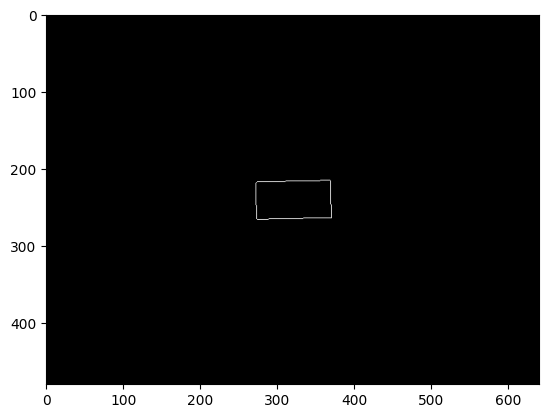

In [3]:
img = cv2.imread("./data/post_manip_data/image_0_1.png", 0)
_, boundary = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
# boundary = cv2.Canny(img,100,200)

# kernel = np.ones((3,3),np.uint8)
# mask = cv2.morphologyEx(boundary, cv2.MORPH_CLOSE, kernel)

plt.imshow(boundary, cmap="gray")

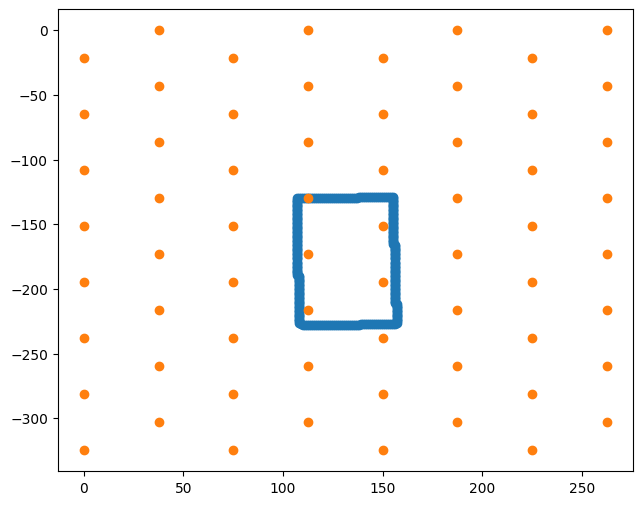

In [4]:
##### SIM CAMERA CALIBRATION #####
boundary_pts = np.array(np.where(boundary==255)).T
min_x, min_y = np.min(boundary_pts, axis=0)
max_x, max_y = np.max(boundary_pts, axis=0)
plane_size = 1000*np.array([(0.132-0.025, -0.179-0.05),(0.132+0.025, -0.179+0.05)])

boundary_pts[:,0] = (boundary_pts[:,0] - min_x)/(max_x-min_x)*(plane_size[1][0]-plane_size[0][0])+plane_size[0][0]
boundary_pts[:,1] = (boundary_pts[:,1] - min_y)/(max_y-min_y)*(plane_size[1][1]-plane_size[0][1])+plane_size[0][1]


f = plt.figure(figsize=(6*1.237169,6)) 
ax = f.add_subplot(111)
ax.scatter(boundary_pts[:,0],boundary_pts[:,1])
ax.scatter(nn_helper.kdtree_positions[:,0],nn_helper.kdtree_positions[:,1])

In [39]:
R = np.array([[0, -1],[1, 0]])
T = np.array([[75, -140]])

In [47]:
com = np.mean(boundary_pts, axis=0)
bp2 = ((boundary_pts-com)@R + com) + T

M2 = icp(boundary_pts, bp2, icp_radius=1000)
TF_Matrix = np.eye(3)
TF_Matrix[:2, :2] = M2[:2, :2]
TF_Matrix[:2, -1] = M2[:2, -1]


In [48]:
TF_Matrix

array([[-2.68141285e-02,  9.99640437e-01,  3.88061691e+02],
       [ 9.99640437e-01,  2.68141285e-02, -4.44771452e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [59]:
np.mean(b-a, axis=1)

array([  74.83419575, -138.37197431])

{(2, 4), (5, 4), (4, 2), (4, 5), (3, 3), (3, 2), (6, 3), (3, 5)} {(5, 3), (3, 4), (4, 4), (4, 3)}


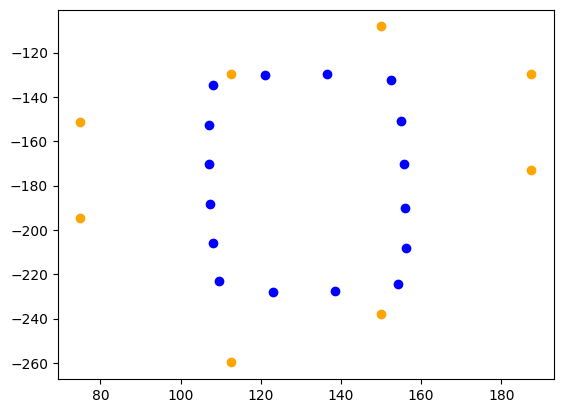

In [77]:
idxs, neg_idxs, DG, pos = nn_helper.get_nn_robots(boundary_pts, 16)
print(idxs, neg_idxs)
idxs = np.array(list(idxs))
neg_idxs = np.array(list(neg_idxs))
a = nn_helper.cluster_centers.T
p = nn_helper.robot_positions[idxs[:,0], idxs[:,1]].T
plt.scatter(*nn_helper.cluster_centers.T, color='blue')
plt.scatter(*nn_helper.robot_positions[idxs[:,0], idxs[:,1]].T, color='orange')
# plt.scatter(*nn_helper.robot_positions[neg_idxs[:,0], neg_idxs[:,1]].T, color='red')

# idxs, neg_idxs, DG, pos = nn_helper.get_nn_robots(((boundary_pts-com)@R + com) + T, 16)
# print(idxs, neg_idxs)
# idxs = np.array(list(idxs))
# neg_idxs = np.array(list(neg_idxs))
# b = nn_helper.cluster_centers.T
# plt.scatter(*nn_helper.cluster_centers.T, color='red')
# plt.quiver(*p, *np.mean(b-a, axis=1), scale=1000)
# plt.scatter(*nn_helper.robot_positions[idxs[:,0], idxs[:,1]].T)
# plt.scatter(*nn_helper.robot_positions[neg_idxs[:,0], neg_idxs[:,1]].T, color='red')

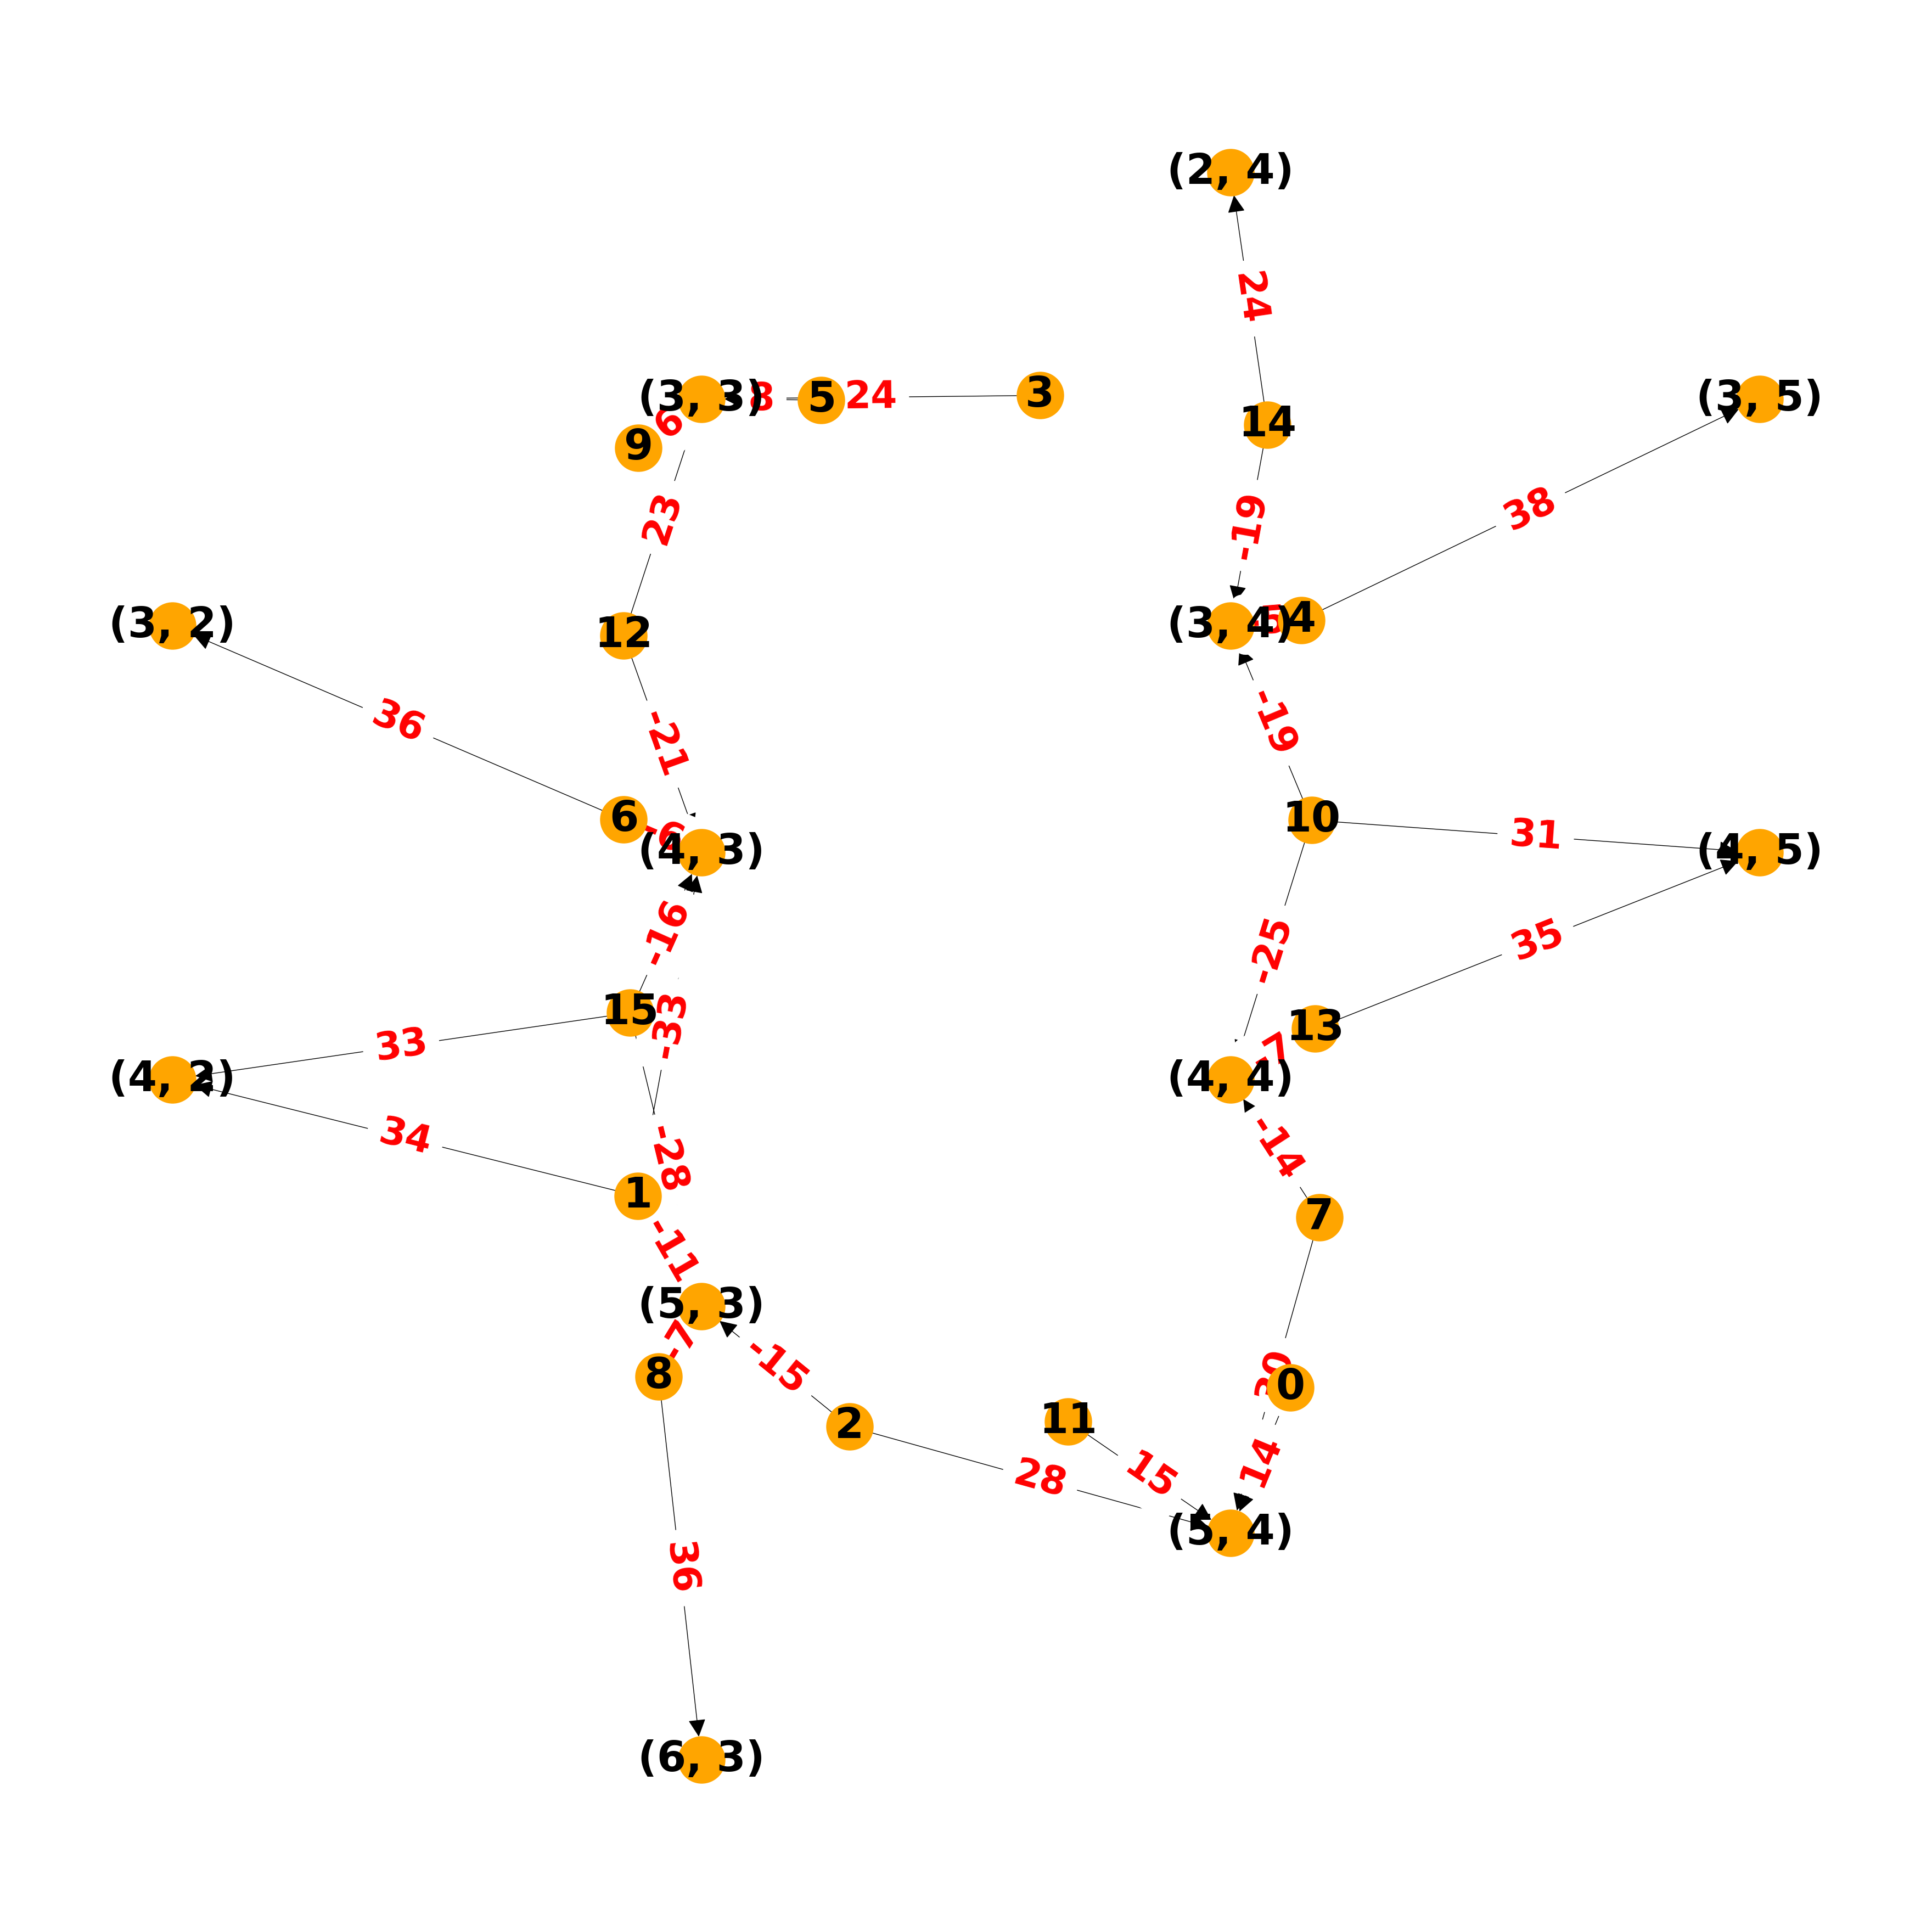

In [78]:
nn_helper.draw_graph(DG, pos, scale=5)

In [47]:
df = pd.read_csv('./data/post_manip_data/data_0_2.csv')
x_cols = [i for i in df.columns if ('x' in i) and (i!="com_x1")]
y_cols = [i for i in df.columns if 'y' in i  and (i!="com_y1")]
# data = df[['com_x1', 'com_x2', "com_y1", "com_y2"]]
X = 1000*df[x_cols].to_numpy() #[:2000]
Y = 1000*df[y_cols].to_numpy() #[:2000]
X.shape, 

((11341, 65),)

In [14]:
n_samples = 1000
noise = 1

# x1 = np.array([1.2]*1000)
x1 = np.random.uniform(-2.5, 2.5, n_samples)
x3 = np.random.uniform(-2.5, 2.5, n_samples)
x7 = np.random.uniform(-2.5, 2.5, n_samples)

x2 = x1 + x3 + noise*np.random.uniform(-2.5, 2.5, n_samples)
x4 = x2 + noise*np.random.uniform(-2.5, 2.5, n_samples)
x5 = x4 + noise*np.random.uniform(-2.5, 2.5, n_samples)
x6 = x2 + x5 + x7 + noise*np.random.uniform(-2.5, 2.5, n_samples)
x8 = x6 + noise*np.random.uniform(-2.5, 2.5, n_samples)
data = np.vstack([x1,x2,x3,x4,x5,x6,x7,x8])
data

array([[ 0.65845632, -0.20767447,  1.71684138, ...,  0.81992663,
        -1.41512745, -2.2928187 ],
       [ 1.08891685, -1.58521689,  0.78645738, ...,  0.49177266,
        -4.16416258, -3.90050465],
       [ 1.49723142, -0.739488  ,  0.384204  , ...,  1.74538494,
        -1.89947686,  0.31887593],
       ...,
       [-2.56846721, -3.08034157, -1.25110567, ...,  1.43810967,
        -5.80733363, -7.71784941],
       [-0.98704281,  0.19935317, -1.42193412, ...,  0.46238517,
        -0.92448312,  0.39282852],
       [-3.39582995, -2.7976246 , -0.62101194, ...,  1.3520376 ,
        -7.80427885, -7.8208719 ]])

In [46]:
a = np.array([28,36,39,47,31])
a//8, a%8

(array([3, 4, 4, 5, 3]), array([4, 4, 7, 7, 7]))

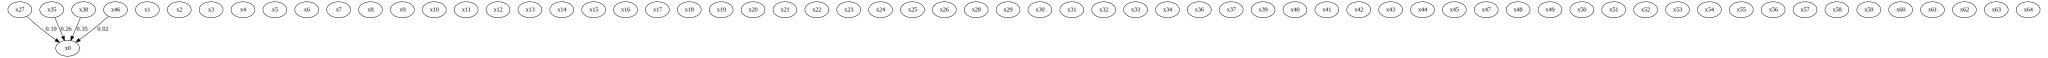

In [48]:
model = lingam.DirectLiNGAM()
model.fit(X)
# model.adjacency_matrix_[model.adjacency_matrix_<0.4] = 0
make_dot(model.adjacency_matrix_)

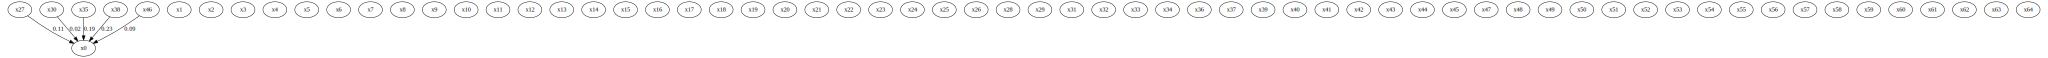

In [49]:
model = lingam.DirectLiNGAM()
model.fit(Y)
# model.adjacency_matrix_[model.adjacency_matrix_<0.4] = 0
make_dot(model.adjacency_matrix_)

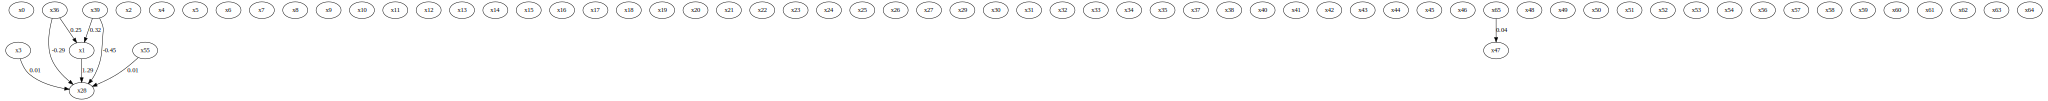

In [65]:
model = lingam.ICALiNGAM(7898978, 1000)
model.fit(X)
make_dot(model.adjacency_matrix_)

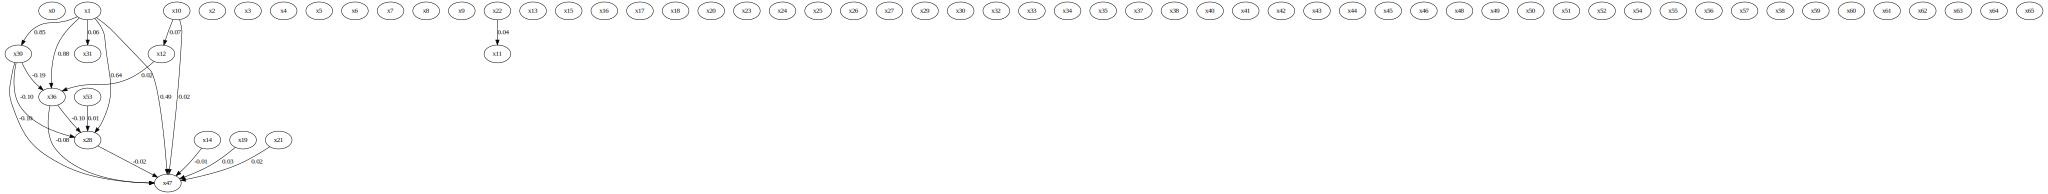

In [66]:
model = lingam.ICALiNGAM(5, 1000)
model.fit(Y)
make_dot(model.adjacency_matrix_)

In [45]:
cg = pc(X, 0.00005, 'fisherz')
# G, edges = fci(X, 'chisq', 0.05, 2)

  0%|          | 0/65 [00:00<?, ?it/s]

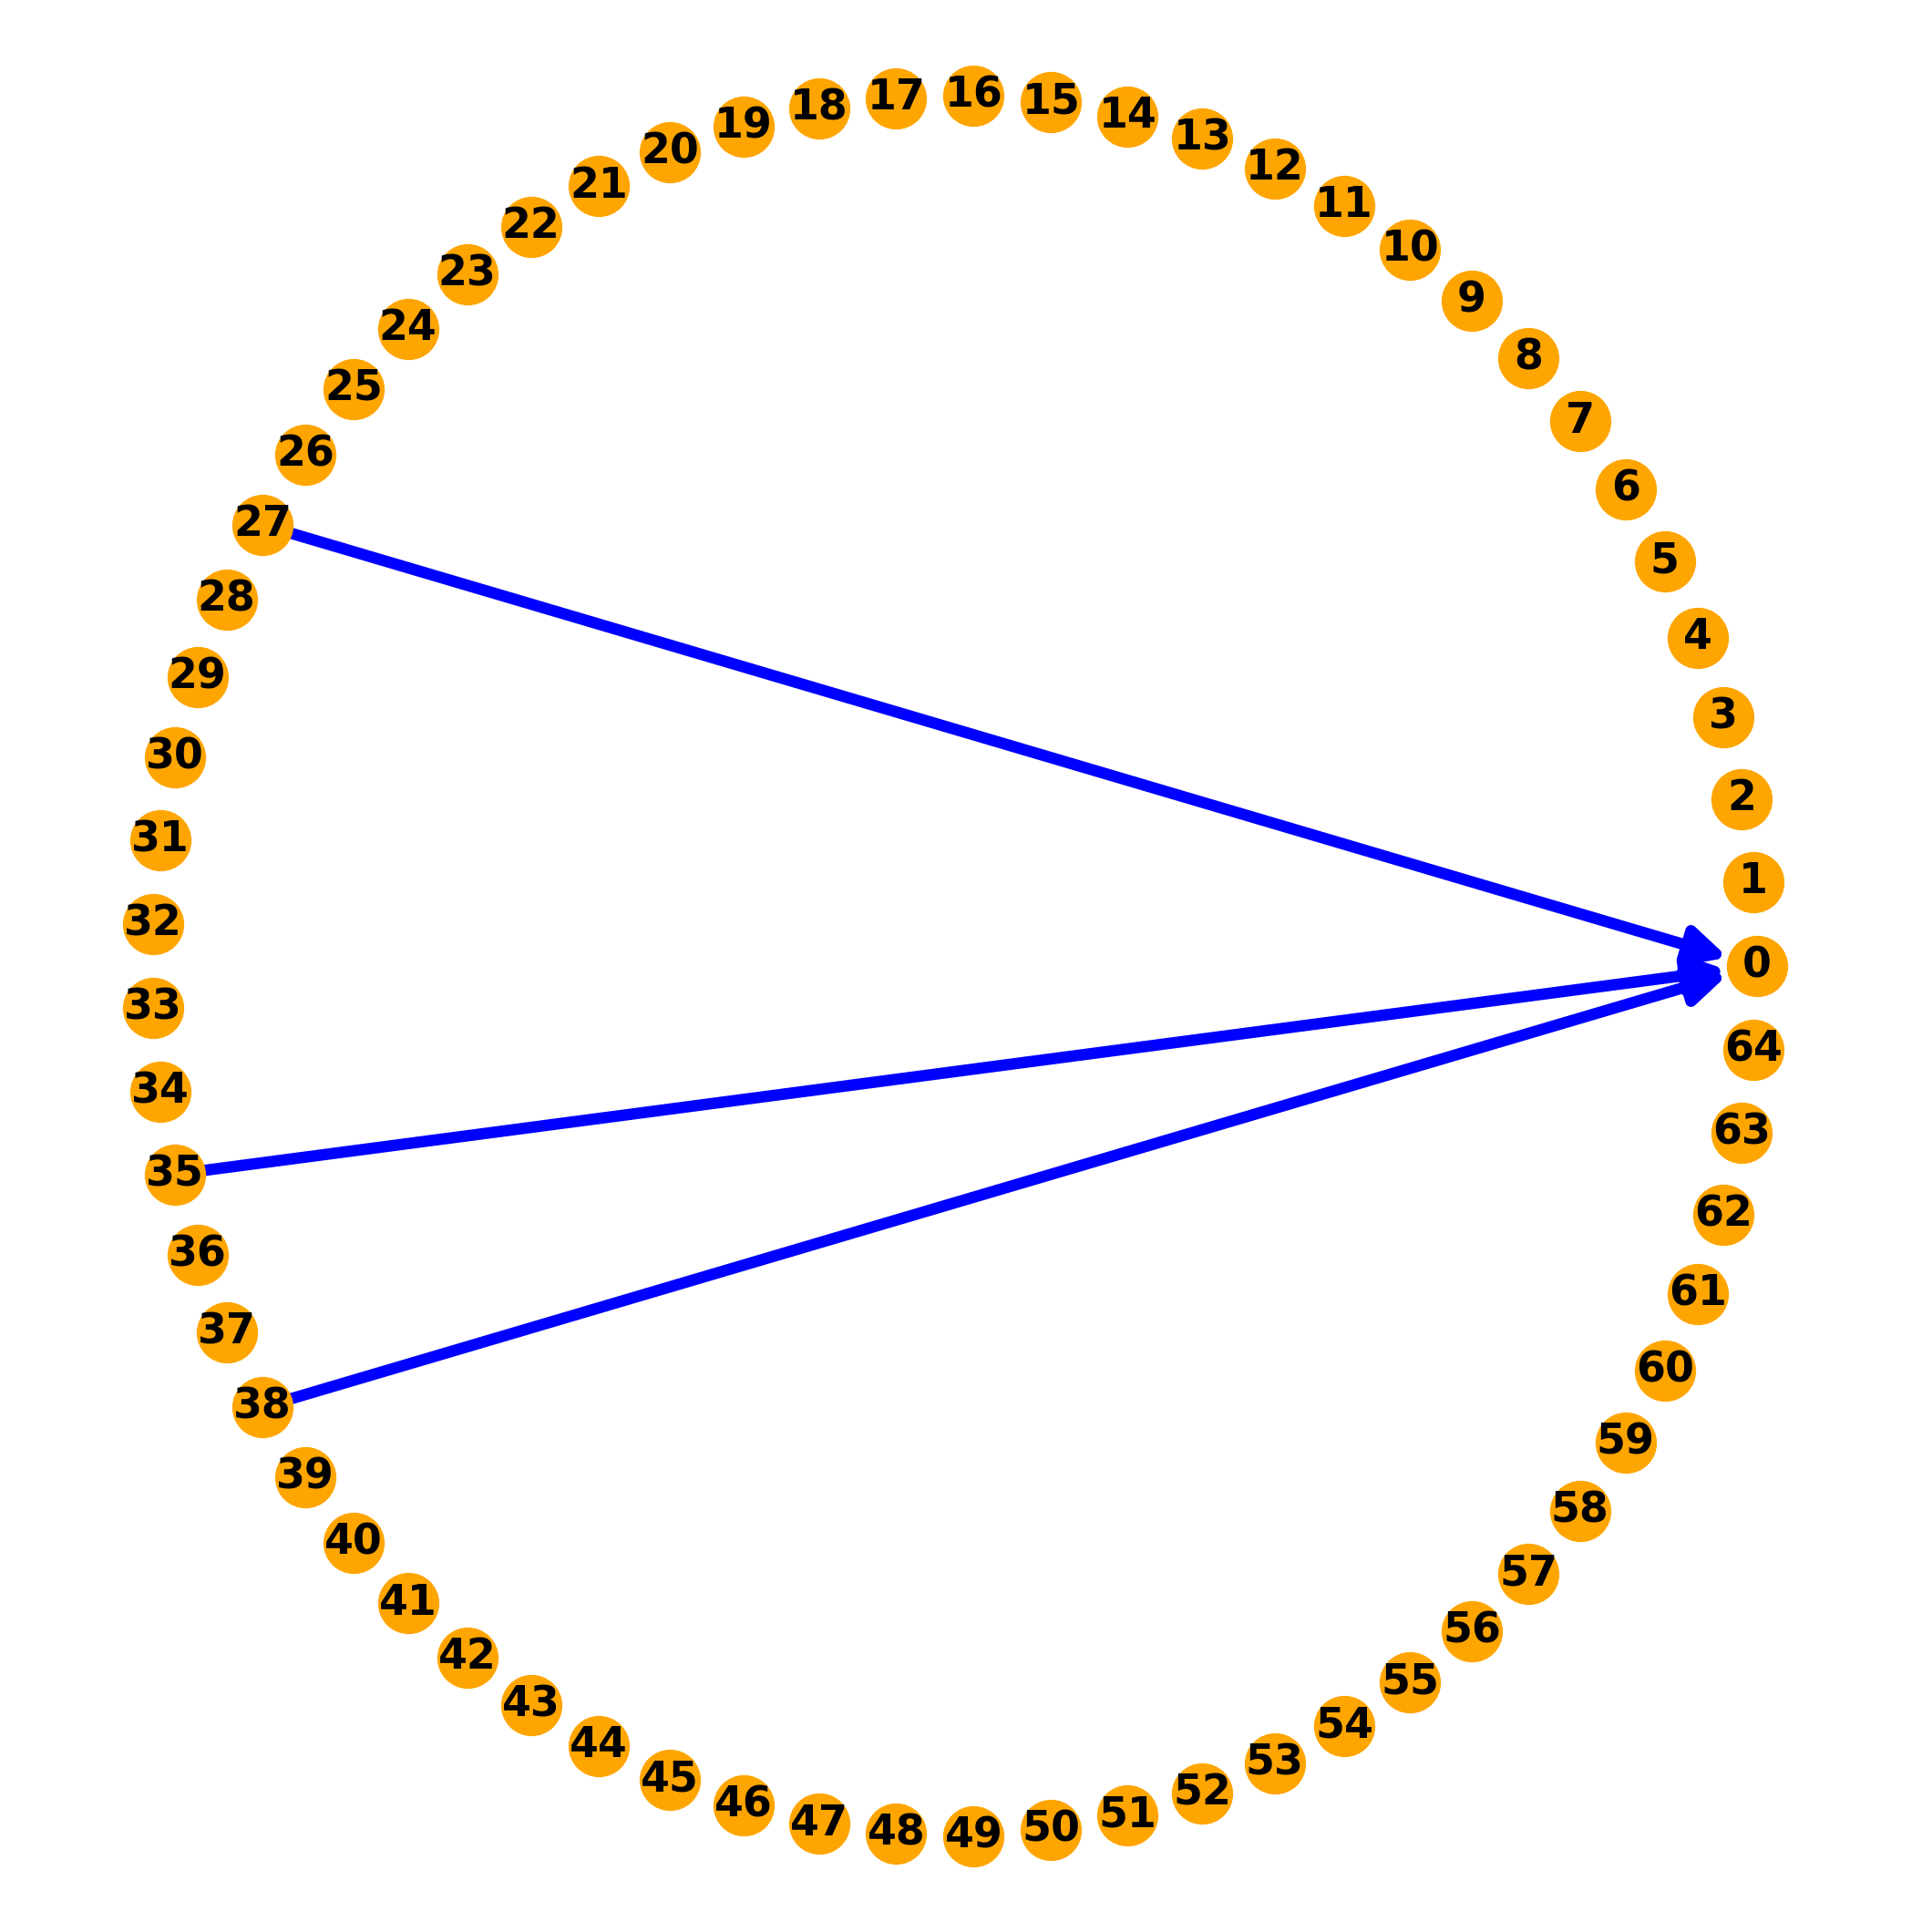

array([[3, 4, 4],
       [3, 3, 6]])

In [46]:
cg.to_nx_graph()
nn_helper.draw_plain_graph(cg.nx_graph, scale=3)

a = np.array(cg.nx_graph.edges)[:,0]
np.vstack((a//8, a%8))

In [ ]:
def to_nx_graph(G):
    """Convert adjmat into a networkx.Digraph object named nx_graph"""
    nodes = range(len(G.graph))
    nx_graph = nx.DiGraph()  # store the directed graph
    self.labels = {i: G.nodes[i].get_name() for i in nodes}
    self.nx_graph.add_nodes_from(nodes)
    undirected = self.find_undirected()
    directed = self.find_fully_directed()
    bidirected = self.find_bi_directed()
    for (i, j) in undirected:
        self.nx_graph.add_edge(i, j, color='g')  # Green edge: undirected edge
    for (i, j) in directed:
        self.nx_graph.add_edge(i, j, color='b')  # Blue edge: directed edge
    for (i, j) in bidirected:
        self.nx_graph.add_edge(i, j, color='r')  # Red edge: bidirected edge

In [37]:
cg, edges = fci(Y, 'fisherz', 0.00005)
nn_helper.draw_plain_graph(cg.no, scale=3)
plt.show()

  0%|          | 0/65 [00:00<?, ?it/s]

TypeError: 'GeneralGraph' object is not iterable

<Figure size 2100x2100 with 0 Axes>

In [26]:
a = 0
while a< 64*50:
    b = a//50
    print(b//8, b%8)
    a += 1
    if a%10==0:
        print("HAKUNA")

0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
HAKUNA
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
HAKUNA
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
HAKUNA
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
HAKUNA
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
HAKUNA
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
HAKUNA
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
HAKUNA
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
HAKUNA
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
HAKUNA
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
HAKUNA
0 2
0 2
0 2
0 2
0 2
0 2
0 2
0 2
0 2
0 2
HAKUNA
0 2
0 2
0 2
0 2
0 2
0 2
0 2
0 2
0 2
0 2
HAKUNA
0 2
0 2
0 2
0 2
0 2
0 2
0 2
0 2
0 2
0 2
HAKUNA
0 2
0 2
0 2
0 2
0 2
0 2
0 2
0 2
0 2
0 2
HAKUNA
0 2
0 2
0 2
0 2
0 2
0 2
0 2
0 2
0 2
0 2
HAKUNA
0 3
0 3
0 3
0 3
0 3
0 3
0 3
0 3
0 3
0 3
HAKUNA
0 3
0 3
0 3
0 3
0 3
0 3
0 3
0 3
0 3
0 3
HAKUNA
0 3
0 3
0 3
0 3
0 3
0 3
0 3
0 3
0 3
0 3
HAKUNA
0 3
0 3
0 3
0 3
0 3
0 3
0 3
0 3
0 3
0 3
HAKUNA
0 3
0 3
0 3
0 3
0 3
0 3
0 3
0 3
0 3
0 3
HAKUNA
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
0 4
HAKUNA
0 4
0 4
0 4
0

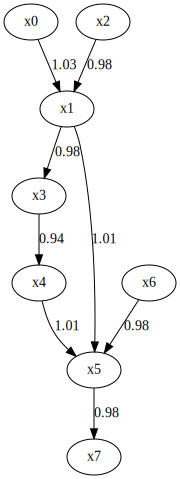

In [20]:
model = lingam.DirectLiNGAM()
model.fit(data.T)
model.adjacency_matrix_[model.adjacency_matrix_<0.4] = 0
make_dot(model.adjacency_matrix_)

In [ ]:
model = lingam.ICALiNGAM(5, 10000)
model.fit(data.T)

print(model.causal_order_)
print(model.adjacency_matrix_)
L = np.tril(model.adjacency_matrix_)
perm = np.argsort(L, axis=0)

# P, L, U = scipy.linalg.lu(np.eye(model.adjacency_matrix_.shape[0]) + model.adjacency_matrix_)
sns.heatmap(L), model.causal_order_

In [ ]:
G = nx.DiGraph()

# add edges to the graph
for i in range(L.shape[0]):
    for j in range(i):
        if L[i][j] != 0:
            G.add_edge(i+1, j+1)
            
nn_helper.draw_graph(G)